In [1]:
# http://pytorch.org/
!pip3 install torch -U # --force
!pip3 install torchvision -U  #--force
!pip3 install https://github.com/chengs/tqdm/archive/colab.zip
!pip3 install bokeh

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (0.4.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
     - 501kB 4.7MB/s
  Running setup.py bdist_wheel for tqdm ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-8crr4w57/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm


https://github.com/theeluwin/pytorch-sgns

In [2]:
import pandas as pd
import numpy as np

from collections import Counter
import operator
import random

import urllib.request

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show, output_notebook, push_notebook, export_png

output_notebook()

Loading BokehJS ...

In [0]:
class SkipGram(nn.Module):
    
    def __init__(self, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.in_embedding = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embedding_dim)
        self.out_embedding = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim =self.embedding_dim)
        
        self.in_embedding.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embedding_dim), torch.FloatTensor(self.vocab_size - 1, self.embedding_dim).uniform_(-0.5 / self.embedding_dim, 0.5 / self.embedding_dim)]))
        self.out_embedding.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embedding_dim), torch.FloatTensor(self.vocab_size - 1, self.embedding_dim).uniform_(-0.5 / self.embedding_dim, 0.5 / self.embedding_dim)]))
        
        self.in_embedding.weight.requires_grad = True
        self.out_embedding.weight.requires_grad = True
        
    def forward(self, center, context, evaluate=False):
#         batch_size = center.size()[0]
#         context_size = context.size()[1]        
        center_vectors = self.in_embedding(center).unsqueeze(2)
        context_vectors = self.out_embedding(context)
        
        loss = torch.bmm(context_vectors, center_vectors).squeeze().sigmoid().log().mean(1)
        
#         loss = torch.mean(torch.bmm(context_vectors, center_vectors) * center.shape[0])
        
        if evaluate:
            output = torch.bmm(context_vectors, center_vectors).squeeze()
            output = torch.exp(output)/torch.sum(output)
            
            return -loss.mean(), output
        else:
            return -loss.mean()
        

In [0]:
class Preprocess(object):
    
    def __init__(self, window_size, unk):
        self.window = window_size
        self.unk = unk
        
    def skipgram(self, sentence, i):
        center = sentence[i]
        left = sentence[max(i-self.window, 0): i]
        right = sentence[i:i+1: i+1+self.window]
                
        return center, [self.unk for _ in range(self.window - len(left))] + left + right + [self.unk for _ in range(self.window - len(right))]
    
    def build(self, url, subsampling=True, threshold=1e-5, word2idx=None):
        print("Creating vocab")
        
        response = urllib.request.urlopen(url)
        
        self.wc = {self.unk: 1}
        for line in response.readlines():
            for word in line.split():
                w = word.decode()
                self.wc[w] = self.wc.get(w, 0) + 1
                                
        self.idx2word = [self.unk] + sorted(self.wc, key=self.wc.get, reverse=True)      
        self.word2idx = {self.idx2word[idx]: idx for idx, _ in enumerate(self.idx2word)}
        
        if word2idx is not None:
            self.word2idx = word2idx
        
        self.vocab = set([word for word in self.word2idx])
        self.vocab_size = len(self.vocab)
                
        print("Done with building vocab")
        
        if subsampling:
            self.subsampling(self.wc, threshold)
        
        self.convert(url, subsampling, word2idx)
        
    def subsampling(self, counts, threshold):
        
        N = sum(counts.values())
        
        freqs = {w: c/N for (w,c) in counts.items()}
        
        discard_table = {w:1-np.sqrt(threshold/f) for (w,f) in freqs.items()}
        
        self.discard_table = discard_table
        
    def discard(self, word_id):
        return random.random() > self.discard_table[word_id]
        
    def convert(self, url, subsampling, word2idx):
        print("Converting corpus")
        data = []
        sentences = []
        response = urllib.request.urlopen(url)
        
        for line in response.readlines():
            sent = []
            for word in line.split():
                w = word.decode()
                
                if subsampling and self.discard(w):
                    continue
                
                if w in self.vocab:
                    sent.append(w)
                else:
                    sent.append(self.unk)
            for i in range(len(sent)):
                center, contexts = self.skipgram(sent, i)
                data.append((self.word2idx[center], np.array([self.word2idx[context] for context in contexts])))
            
            sentences.append(sent)
        self.data = data
        self.sentences = sentences
        print("Done")
        
                
                
    

In [5]:
window_size = 5
unk = "<unk>"

print("Train...")
url_train = 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.train.txt'
preprocess_train = Preprocess(window_size=window_size, unk=unk)
preprocess_train.build(url_train, subsampling=True)

print("Valid...")
url_valid = 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.valid.txt'
preprocess_valid = Preprocess(window_size=window_size, unk=unk)
preprocess_valid.build(url_valid, subsampling=True, word2idx=preprocess_train.word2idx)

Train...
Creating vocab
Done with building vocab
Converting corpus
Done
Valid...
Creating vocab
Done with building vocab
Converting corpus
Done


In [6]:
net = SkipGram(vocab_size = preprocess_train.vocab_size+1, embedding_dim=50)
print(net)

SkipGram(
  (in_embedding): Embedding(10000, 50)
  (out_embedding): Embedding(10000, 50)
)


In [0]:
optimizer = optim.Adam(net.parameters())
# optimizer.param_groups

In [0]:
train_loader = data_utils.DataLoader(preprocess_train.data, batch_size=128, shuffle=True)
valid_loader = data_utils.DataLoader(preprocess_valid.data, batch_size=128, shuffle=True)

In [9]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Cuda available")
    net.cuda()

Cuda available


In [0]:
# center, contexts = next(iter(train_loader))
# print(center.shape, contexts.shape)
# torch.mean(net(center.long(), contexts.long()) * center.shape[0])

In [0]:
from tqdm import tqdm
from time import sleep

valid_loss = []
train_loss = []

epochs = 10
for epoch in range(epochs):
    pbar_train = tqdm(train_loader,position=0)
    pbar_valid = tqdm(valid_loader,position=0)

    pbar_train.set_description("[Epoch {}, train]".format(epoch+1))
    pbar_valid.set_description("[Epoch {}, valid]".format(epoch+1))
    
    running_loss, running_length = 0, 0
    
    net.train()
    for center, contexts in pbar_train:
        
        center = center.long()
        contexts = contexts.long()
        
        if use_cuda:
            center = center.cuda()
            contexts = contexts.cuda()
        
        loss = net(center, contexts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_length += center.shape[0]
        
        pbar_train.set_postfix(loss=running_loss, perplexity=np.exp(running_loss))
        
    train_loss.append(running_loss)

    net.eval()
    running_loss, running_length = 0, 0 
    
    for center, context in pbar_valid:
        center = center.long()
        context = context.long()
        
        if use_cuda:
            center = center.cuda()
            context = context.cuda()
        
        loss = net(center, context)
        
        running_loss += loss.item()
        running_length += center.shape[0]
        
        pbar_valid.set_postfix(loss=running_loss, perplexity=np.exp(running_loss))
        
    valid_loss.append(running_loss)
    
#     print("Epoch: {}, Train loss: {:.3f}, Perplexity: {:.3f}".format(epoch+1, train_loss[-1], np.exp(train_loss[-1])))

#     print("Epoch: {}, Valid loss: {:.3f}, Perplexity: {:.3f}".format(epoch+1, valid_loss[-1], np.exp(valid_loss[-1])))

[Epoch 9, train]:  52%|█████▏    | 2902/5619 [00:30<00:28, 96.19it/s, loss=0.00412, perplexity=1]

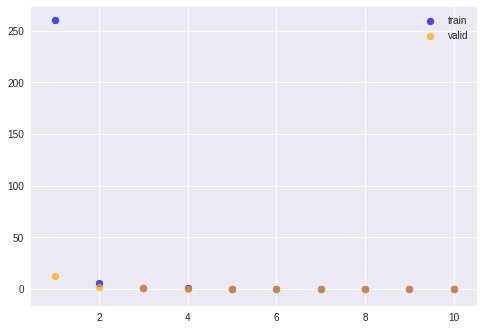

In [0]:
plt.figure()
plt.scatter(list(range(1,epochs+1)), train_loss, color='blue', alpha=0.7, label='train')
plt.scatter(list(range(1,epochs+1)), valid_loss, color='orange', alpha=0.7, label='valid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
url_train = 'https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt'
preprocess_test = Preprocess(window_size=window_size, unk=unk)
preprocess_test.build(url_train, subsampling=True, word2idx=preprocess_train.word2idx)

Creating vocab
Done with building vocab
Converting corpus
Done


In [0]:
model = TSNE(n_components=2, perplexity=30, n_iter=5000, method='exact', verbose=1)

idx2vec = net.in_embedding.weight.data.cpu().numpy()
word2idx = preprocess_train.word2idx

top_k_words = 500

words_train = sorted(preprocess_train.wc, key=preprocess_train.wc.get, reverse=True)
words_train_array = np.array(words_train)
sampled_words_train = words_train_array[:top_k_words] #np.random.choice(words_train_array, size=1000)

X_train = np.array([idx2vec[word2idx[word]] for word in sampled_words_train])
X_train = model.fit_transform(X_train)

words_test = sorted(preprocess_test.wc, key=preprocess_test.wc.get, reverse=True)
words_test_array = np.array(words_test)
sampled_words_test = words_test_array[:top_k_words] # np.random.choice(words_test_array, size=1000)

X_test=np.array([idx2vec[word2idx[word]] for word in sampled_words_test])
X_test=model.fit_transform(X_test)

output_notebook()
source_train = ColumnDataSource(
    data=dict(x=X_train[:,0], y=X_train[:,1], w=sampled_words_train)
)
source_test = ColumnDataSource(
    data=dict(x=X_test[:,0], y=X_test[:,1], w=sampled_words_test)
)
hover_tool = HoverTool(tooltips=[("word", "@w")])

p = figure(plot_width=600, plot_height=600, title="t-SNE, top {} words".format(top_k_words))
p.scatter('x', 'y', color='blue', alpha=0.7, source=source_train, name="train", legend="train")
p.scatter('x', 'y', color='orange', alpha=0.7, source=source_test, name="test", legend="test")

p.add_tools(hover_tool)

show(p)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.029444
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.788505
[t-SNE] Error after 5000 iterations: 0.294492
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.032059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.802087
[t-SNE] Error after 5000 iterations: 0.261760


Loading BokehJS ...

In [0]:
# pick random sentence and convert it to idx
idx2word = preprocess_train.idx2word
random_sentence = np.random.choice(np.array(preprocess_test.sentences), size=1)[0]
print(" ".join(random_sentence))
random_sentence = [preprocess_train.word2idx[w] for w in random_sentence]

# get network to predict context from a center

random_center = np.random.randint(low=0, high=len(random_sentence), size=1)[0]
print("Random center at {} being the word '{}'".format(random_center, idx2word[random_sentence[random_center]]))



gm said it still is talking with jaguar about acquiring a minority
Random center at 11 being the word 'minority'


In [0]:
data = preprocess_train.skipgram(sentence=random_sentence, i=random_center)

In [0]:
torch.LongTensor(data[0])

tensor([      171360256,               0,        10910368,  ...,
        140287360429448, 140289211779368, 140287360431536])

In [0]:
 center, contexts = preprocess_train.skipgram(sentence=random_sentence, i=random_center)
# (word2idx[center], np.array([word2idx[context] for context in contexts]))
contexts = np.array([word2idx[context] if isinstance(context, str) else context for context in contexts])

center = torch.tensor(center).long().cuda()
contexts = torch.tensor(contexts).long().cuda()

center_vec = net.in_embedding(center)
contexts_vec = net.out_embedding(contexts)


In [0]:
# output = torch.bmm(context_vectors, center_vectors).squeeze()
# output = torch.exp(output)/torch.sum(output

torch.bmm(contexts_vec, center_vec.unsqueeze(1))

RuntimeError: ignored